In [1]:
from pytorch3d.io import load_obj


## Esse teste tem funcionado e deforma corretamente a malha

In [2]:
import torch
from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj
import numpy as np
import warnings
from math import comb
import torch.nn as nn

class FreeFormDeformation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, verts, control_points, control_points_delta, l, m, n):
        """
        Aplica deformação FFD a uma malha.
        
        Args:
            verts: Vértices da malha (N, 3).
            control_points: Pontos de controle da malha FFD (l, m, n, 3).
            control_points_delta: Deltas a serem aplicados nos pontos de controle (l, m, n, 3).
            l, m, n: Dimensões da grade de controle FFD.

        Returns:
            verts_deformed: Vértices da malha após a deformação FFD.
        """
        updated_control_points = control_points + control_points_delta
        deformed_verts = torch.zeros_like(verts)

        # Armazena para o backward
        ctx.save_for_backward(verts, control_points, control_points_delta)
        ctx.l, ctx.m, ctx.n = l, m, n

        # Itera sobre os vértices da malha
        for v_idx, v in enumerate(verts):
            u, v, w = v  # Assumindo os vértices normalizados no intervalo [0, 1]
            new_vert = torch.zeros(3, dtype=verts.dtype, device=verts.device)

            for i in range(l):
                for j in range(m):
                    for k in range(n):
                        B_i = FreeFormDeformation.bernstein(i, l - 1, u)
                        B_j = FreeFormDeformation.bernstein(j, m - 1, v)
                        B_k = FreeFormDeformation.bernstein(k, n - 1, w)
                        new_vert += B_i * B_j * B_k * updated_control_points[i*(l**2) + j*m + k]
            
            deformed_verts[v_idx] = new_vert
        
        return deformed_verts

        ### Tentativa de 
        # # Atualiza os pontos de controle
        # updated_control_points = control_points + control_points_delta

        # # Salva variáveis para o backward
        # ctx.save_for_backward(verts, control_points, control_points_delta)
        # ctx.l, ctx.m, ctx.n = l, m, n

        # # Calcula os polinômios de Bernstein para todos os pontos
        # u, v, w = verts[..., 0], verts[..., 1], verts[..., 2]  # Coordenadas dos pontos (m, 3)

        # B_u = torch.stack([FreeFormDeformation.bernstein(i, l - 1, u) for i in range(l)], dim=-1)  # (m, l)
        # B_v = torch.stack([FreeFormDeformation.bernstein(j, m - 1, v) for j in range(m)], dim=-1)  # (m, m)
        # B_w = torch.stack([FreeFormDeformation.bernstein(k, n - 1, w) for k in range(n)], dim=-1)  # (m, n)

        # %debug
        # # Realiza o produto tensorial entre os polinômios de Bernstein
        # B_uv = B_u.unsqueeze(-1) * B_v.unsqueeze(-2)  # (m, l, m)
        # B_uvw = B_uv.unsqueeze(-1) * B_w.unsqueeze(-2)  # (m, l, m, n)

        # # Transforma os pontos de controle para o formato apropriado
        # # (l, m, n, 3) -> (1, l, m, n, 3) para broadcast
        # updated_control_points = updated_control_points.unsqueeze(0)

        # # Multiplica os pesos de Bernstein pelos pontos de controle
        # deformed_points = torch.sum(B_uvw[..., None] * updated_control_points, dim=(1, 2, 3))  # (m, 3)

        # return deformed_points


    @staticmethod
    def bernstein(i, n, u):
        """Calcula o polinômio de Bernstein para FFD."""
        return torch.tensor(comb(n, i), dtype=u.dtype, device=u.device) * (u ** i) * ((1 - u) ** (n - i))

    @staticmethod
    def bernstein_gradient(i, n, u):
        """Calcula o polinômio de Bernstein para FFD."""
        return -u**(-1+i) * torch.tensor(comb(n, i), dtype=u.dtype, device=u.device) * (n*u-i) * ((1-u)**(n-1-i))
    
    @staticmethod
    def backward(ctx, grad_output):
        verts, control_points, control_points_delta = ctx.saved_tensors
        l, m, n = ctx.l, ctx.m, ctx.n

        grad_control_points_delta = torch.zeros_like(control_points_delta)

        for v_idx, v in enumerate(verts):
            u, v, w = v
            grad = grad_output[v_idx]

            for i in range(l):
                for j in range(m):
                    for k in range(n):
                        B_i = FreeFormDeformation.bernstein(i, l - 1, u)
                        B_j = FreeFormDeformation.bernstein(j, m - 1, v)
                        B_k = FreeFormDeformation.bernstein(k, n - 1, w)
                        grad_control_points_delta[i*(l**2) + j*m + k] += B_i * B_j * B_k * grad

        return None, None, grad_control_points_delta, None, None, None


class FFDLayer (nn.Module):
    def __init__(self, l, m, n, control_points=None, normalizer = None):
        """
        FFD Layer que aplica a deformação FFD nos vértices da malha.
        """
        self.dimension = (l, m, n)
        
        self.normalizer = normalizer if normalizer else None
        
        self.control_points = control_points if control_points is not None else torch.tensor(np.array([[[[i/(l-1), j/(m-1), k/(n-1)] for k in range(n)] for j in range(m)] for i in range(l)]).reshape(l*m*n,3))
        
        self.l, self.m, self.n = l, m, n

    
    def check_and_normalize(self, points):
        """
        Verifica se os pontos estão normalizados e aplica normalização, se necessário.
        
        Args:
            points: Tensor de pontos a serem verificados e possivelmente normalizados.
            
        Returns:
            points: Tensor de pontos normalizados, se necessário.
        """
        # Verifica se os pontos estão no intervalo [0, 1]
        if not (torch.all(points >= 0) and torch.all(points <= 1)):
            if self.normalizer:
                # Aplica normalizador personalizado
                points = self.normalizer([points])
                warnings.warn("Pontos de entrada foram normalizados usando o `normalizer` fornecido.")
            else:
                # Normaliza automaticamente
                min_vals = points.min(dim=0, keepdim=True)[0]
                max_vals = points.max(dim=0, keepdim=True)[0]
                points = (points - min_vals) / (max_vals - min_vals)
                points = points
                warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")
        
        return points

    def __call__(self, points, control_points_delta):
        """
        Aplica a deformação FFD nos pontos fornecidos após verificação e normalização.
        
        Args:
            points: Tensor de pontos a serem deformados.
            control_points_delta: Tensor de deltas para os pontos de controle.
            
        Returns:
            Tensor de pontos deformados.
        """
        # Verifica e normaliza os pontos, se necessário
        points = self.check_and_normalize(points)
        # Calcula e retorna os pontos deformados com o Free Form Deformation
        return FreeFormDeformation.apply(points, self.control_points, control_points_delta, self.l, self.m, self.n)




In [3]:
import pickle

def save_training_data(filename, data):
    """
    Salva os dados do treinamento em um arquivo pickle.
    
    Args:
        filename (str): Nome do arquivo para salvar os dados.
        data (dict): Dicionário contendo os dados do treinamento.
    """
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Dados salvos em {filename}")

def load_training_data(filename):
    """
    Carrega os dados do treinamento de um arquivo pickle.
    
    Args:
        filename (str): Nome do arquivo para carregar os dados.
        
    Returns:
        dict: Dicionário contendo os dados do treinamento.
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print(f"Dados carregados de {filename}")
    return data


In [22]:
import matplotlib.pyplot as plt

def plot_pointcloud(points, title=""):
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y, s=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

def plot_pointcloud_of_mesh(mesh, title="", resolution = 5000):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, resolution)
    plot_pointcloud(points, title=title)

In [5]:
import torch
from pytorch3d.loss import chamfer_distance, mesh_edge_loss, mesh_normal_consistency, mesh_laplacian_smoothing
from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.utils import ico_sphere
import numpy as np

def train_from_mesh(
    src_mesh, trg_mesh,
    dimension = (3,3,3),
    learning_rate = 0.5,
    # Loss weights
    w_chamfer = 1.0,
    w_edge = 1.0,
    w_normal = 0.01,
    w_laplacian = 0.1,
    print_interval = 10,
    num_iterations = 100,
    num_layers = 3,
    **kwargs
):
    l, m, n = dimension
    error_hist = []
    control_points = torch.tensor(
        np.array([[[[i / (l - 1), j / (m - 1), k / (n - 1)] 
                    for k in range(n)] 
                    for j in range(m)] 
                    for i in range(l)]).reshape(l * m * n, 3),
        requires_grad=False,
        device=device
    )
    
    # Configure FFD layers
    control_points_deltas = [
        torch.zeros((l * m * n, 3), requires_grad=True, device=device) 
        for _ in range(num_layers)
    ]

    ffd_layers = [FFDLayer(l=l, m=m, n=n, control_points=control_points) for _ in range(num_layers)]
    
    # Configure optimizer
    optimizer = torch.optim.SGD(control_points_deltas, lr=learning_rate)
    
    # Training loop
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    src_verts = ffd_layers[0].check_and_normalize(src_mesh.verts_list()[0])

    
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        # Apply FFD layers sequentially
        deformed_verts = src_verts.clone()
        for layer, delta in zip(ffd_layers, control_points_deltas):
            deformed_verts = layer(deformed_verts, delta)
        
        # Create the deformed mesh
        new_src_mesh_ffd = Meshes(verts=[deformed_verts], faces=[src_mesh.faces_packed()])
        
        # Sample points for Chamfer loss
        sample_src_ffd = sample_points_from_meshes(new_src_mesh_ffd, 5000)
        
        # Compute losses
        loss_chamfer_ffd, _ = chamfer_distance(sample_trg, sample_src_ffd)
        loss_edge_ffd = mesh_edge_loss(new_src_mesh_ffd)
        loss_normal_ffd = mesh_normal_consistency(new_src_mesh_ffd)
        loss_laplacian_ffd = mesh_laplacian_smoothing(new_src_mesh_ffd, method="uniform")
        
        # Total loss
        loss_ffd = (loss_chamfer_ffd * w_chamfer +
                    loss_edge_ffd * w_edge +
                    loss_normal_ffd * w_normal +
                    loss_laplacian_ffd * w_laplacian)

        error_hist.append([loss_chamfer_ffd, loss_edge_ffd, loss_normal_ffd, loss_laplacian_ffd])
        
        # Log loss
        print(f'Iteration {i + 1}/{num_iterations}, Loss: {loss_ffd.item():.6f}')
        if i % print_interval == 0:
            plot_pointcloud_of_mesh(new_src_mesh_ffd)
        
        # Backpropagation
        loss_ffd.backward()
        
        # Update control points deltas
        optimizer.step()

    return {'final_mesh' : new_src_mesh_ffd, 'delta_points' : control_points_deltas, 'error_hist' : error_hist}


In [6]:
from pytorch3d.ops import sample_farthest_points

def train_from_points(
    src_points, trg_verts,
    dimension = (3,3,3),
    learning_rate = 0.5,
    # Loss weights
    w_chamfer = 1.0,
    print_interval = 10,
    num_iterations = 100,
    num_layers = 3,
    resolution = 2000,
    **kwargs
):
    l, m, n = dimension
    error_hist = []
    control_points = torch.tensor(
        np.array([[[[i / (l - 1), j / (m - 1), k / (n - 1)] 
                    for k in range(n)] 
                    for j in range(m)] 
                    for i in range(l)]).reshape(l * m * n, 3),
        requires_grad=False,
        device=device
    )
    
    # Configure FFD layers
    control_points_deltas = [
        torch.zeros((l * m * n, 3), requires_grad=True, device=device) 
        for _ in range(num_layers)
    ]

    ffd_layers = [FFDLayer(l=l, m=m, n=n, control_points=control_points) for _ in range(num_layers)]
    
    # Configure optimizer
    optimizer = torch.optim.SGD(control_points_deltas, lr=learning_rate)
    
    # Training loop
    sample_trg_verts, _ = sample_farthest_points(trg_verts, K=resolution)

    src_points = ffd_layers[0].check_and_normalize(src_points[0])
    
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        # Apply FFD layers sequentially
        deformed_verts = src_points.clone()
        
        for layer, delta in zip(ffd_layers, control_points_deltas):
            deformed_verts = layer(deformed_verts, delta)
            
        # Sample points for Chamfer loss
        # sample_src_ffd = sample_points_from_meshes(new_src_mesh_ffd, 5000)
        
        # Amostra 1000 pontos com Farthest Point Sampling
        sampled_points, _ = sample_farthest_points(deformed_verts.unsqueeze(0), K=resolution)
        
        # Compute losses
        loss_chamfer_ffd, _ = chamfer_distance(sample_trg_verts, sampled_points)
        
        # Total loss
        loss_ffd = (loss_chamfer_ffd * w_chamfer)

        error_hist.append(loss_chamfer_ffd)
        
        # Log loss
        print(f'Iteration {i + 1}/{num_iterations}, Loss: {loss_ffd.item():.6f}')
        if i % print_interval == 0:
            plot_pointcloud(deformed_verts)
        
        # Backpropagation
        loss_ffd.backward()
        
        # Update control points deltas
        optimizer.step()

    return {'final_verts' : deformed_verts, 'delta_points' : control_points_deltas, 'error_hist' : error_hist}


## Agora um teste utilizando multiplas camadas sequenciais de Free Form Deformation

Esse não deu certo, o gradiente não está sendo calculado para as camadas iniciais da rede, apenas na ultima camada a de saída. Deve existir algum erro, possivelmente os retorno do Backpropagation são insuficientes para gerar corretamente o grafo de autograd.

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")
    
# Load target mesh and normalize
trg_obj = 'dolphin.obj'
trg_verts, trg_faces, _ = load_obj(trg_obj)
min_vals = trg_verts.min(dim=0, keepdim=True)[0]
max_vals = trg_verts.max(dim=0, keepdim=True)[0]
trg_verts = (trg_verts - min_vals) / (max_vals - min_vals)
trg_mesh = Meshes(verts=[trg_verts], faces=[trg_faces.verts_idx])

# Load source mesh and normalize
src_mesh = ico_sphere(4, device=device)
src_verts = src_mesh.verts_packed()
min_vals = src_verts.min(dim=0, keepdim=True)[0]
max_vals = src_verts.max(dim=0, keepdim=True)[0]
src_verts = (src_verts - min_vals) / (max_vals - min_vals)

# Configure FFD control points

# settings = {
#     'num_layers' : 3,
#     'dimension' : (3,3,3), 
#     'learning_rate' : 0.5,
#     # Loss weights
#     'w_chamfer' : 1.0,
#     'w_edge' : 1.0,
#     'w_normal' : 0.01,
#     'w_laplacian' : 0.1,
#     'print_interval' : 2,
#     'num_iterations' : 5
# }

# result = train_from_mesh(src_mesh, trg_mesh,**settings)

# final_mesh = result["final_mesh"]
# deltas = result["delta_points"]
# err_list = result["error_hist"]

# data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
# save_training_data('./traino_1.pkl' , data)

/usr/local/lib/python3.8/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


## Teste para deformar uma malha simplificada dos Crânios

In [ ]:
from plyfile import PlyData, PlyElement
#import open3d as o3d

def read_ply(file_path):
    return PlyData.read(file_path)
    
def load_plydata_into_mesh(filename):

    with open(filename, 'rb') as f3:
        plydata = PlyData.read(f3)
    
    # Load verts
    x = plydata['vertex']['x']
    y = plydata['vertex']['y']
    z = plydata['vertex']['z']

    # Centralize model
    x = x - np.mean(x)
    y = y - np.mean(y)
    z = z - np.mean(z)

    # normalize model
    # max_dist = np.max(np.stack([np.abs(x), np.abs(y), np.abs(y)]))
    # x = x * 10 / max_dist
    # y = y * 10 / max_dist
    # z = z * 10 / max_dist

    verts = np.column_stack([x, y, z])
    verts_tensor_list = [torch.tensor(v) for v in verts]
    vertices_tensor = torch.stack(verts_tensor_list)

    # Load Face
    faces = plydata['face']['vertex_indices']
    # Convert faces to list to be compatible with pytorch3d.structures.meshes
    faces_tensor_list = [torch.tensor(f) for f in faces.tolist()]
    faces_tensor = torch.stack(faces_tensor_list)

    # criando um tensor de cores RGB uniformes para cada vértice
    verts_rgb = torch.ones_like(vertices_tensor)[None]  # (1, V, 3)
    textures = TexturesVertex(verts_features=verts_rgb.to(device))

    # Create Mesh
    mesh = Meshes(verts=[vertices_tensor.to(device)], faces=[faces_tensor.to(device)], textures=textures)

    return mesh

# Exemplo de uso
file_path = '../Modelos/Homo sapiens.ply'
mesh_sapiens = load_plydata_into_mesh(file_path)



## Varios teste de performance

Iteration 1/100, Loss: 0.101918


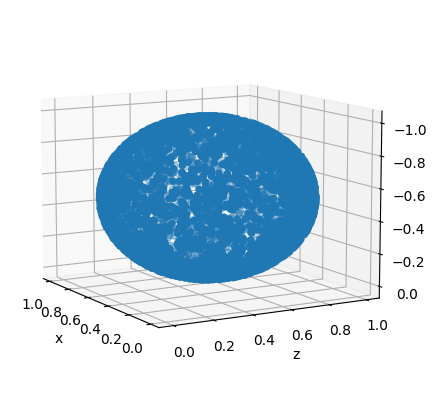

Iteration 2/100, Loss: 0.098099
Iteration 3/100, Loss: 0.093764
Iteration 4/100, Loss: 0.092904
Iteration 5/100, Loss: 0.089042
Iteration 6/100, Loss: 0.085815
Iteration 7/100, Loss: 0.082944
Iteration 8/100, Loss: 0.080214
Iteration 9/100, Loss: 0.078216
Iteration 10/100, Loss: 0.076509
Iteration 11/100, Loss: 0.073420
Iteration 12/100, Loss: 0.071592
Iteration 13/100, Loss: 0.069059
Iteration 14/100, Loss: 0.068886
Iteration 15/100, Loss: 0.065388
Iteration 16/100, Loss: 0.063764
Iteration 17/100, Loss: 0.060956
Iteration 18/100, Loss: 0.059625
Iteration 19/100, Loss: 0.057396
Iteration 20/100, Loss: 0.055817
Iteration 21/100, Loss: 0.054148
Iteration 22/100, Loss: 0.053035
Iteration 23/100, Loss: 0.051092
Iteration 24/100, Loss: 0.049056
Iteration 25/100, Loss: 0.047574
Iteration 26/100, Loss: 0.045926
Iteration 27/100, Loss: 0.044468
Iteration 28/100, Loss: 0.043077
Iteration 29/100, Loss: 0.041963
Iteration 30/100, Loss: 0.040103
Iteration 31/100, Loss: 0.038943
Iteration 32/100, 

In [40]:
settings = {
    'num_layers' : 3,
    'dimension' : (3,3,3), 
    'learning_rate' : 0.5,
    # Loss weights
    'w_chamfer' : 1.0,
    'w_edge' : 1.0,
    'w_normal' : 0.01,
    'w_laplacian' : 0.1,
    'print_interval' : 100,
    'num_iterations' : 100
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_01.pkl' , data)

Iteration 1/100, Loss: 0.099874


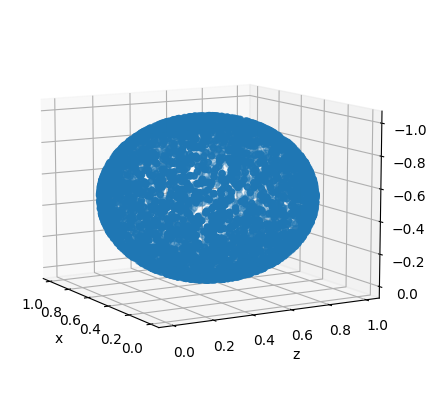

Iteration 2/100, Loss: 0.097712
Iteration 3/100, Loss: 0.094789
Iteration 4/100, Loss: 0.091778
Iteration 5/100, Loss: 0.087160
Iteration 6/100, Loss: 0.087129
Iteration 7/100, Loss: 0.082319
Iteration 8/100, Loss: 0.080144
Iteration 9/100, Loss: 0.077514
Iteration 10/100, Loss: 0.076053
Iteration 11/100, Loss: 0.073851
Iteration 12/100, Loss: 0.071429
Iteration 13/100, Loss: 0.068656
Iteration 14/100, Loss: 0.068855
Iteration 15/100, Loss: 0.065777
Iteration 16/100, Loss: 0.063526
Iteration 17/100, Loss: 0.061775
Iteration 18/100, Loss: 0.059908
Iteration 19/100, Loss: 0.057294
Iteration 20/100, Loss: 0.055293
Iteration 21/100, Loss: 0.054252
Iteration 22/100, Loss: 0.052356
Iteration 23/100, Loss: 0.050493
Iteration 24/100, Loss: 0.049160
Iteration 25/100, Loss: 0.047729
Iteration 26/100, Loss: 0.045851
Iteration 27/100, Loss: 0.044270
Iteration 28/100, Loss: 0.042169
Iteration 29/100, Loss: 0.042344
Iteration 30/100, Loss: 0.040455
Iteration 31/100, Loss: 0.038063
Iteration 32/100, 

In [41]:
settings = {
    'num_layers' : 1,
    'dimension' : (3,3,3), 
    'learning_rate' : 0.5,
    # Loss weights
    'w_chamfer' : 1.0,
    'w_edge' : 1.0,
    'w_normal' : 0.01,
    'w_laplacian' : 0.1,
    'print_interval' : 100,
    'num_iterations' : 100
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_02.pkl' , data)

Iteration 1/500, Loss: 0.098938


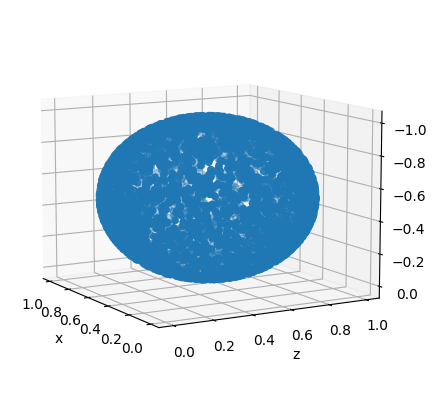

Iteration 2/500, Loss: 0.099455
Iteration 3/500, Loss: 0.093683
Iteration 4/500, Loss: 0.088980
Iteration 5/500, Loss: 0.087857
Iteration 6/500, Loss: 0.086370
Iteration 7/500, Loss: 0.083126
Iteration 8/500, Loss: 0.081712
Iteration 9/500, Loss: 0.076765
Iteration 10/500, Loss: 0.076800
Iteration 11/500, Loss: 0.073226
Iteration 12/500, Loss: 0.071148
Iteration 13/500, Loss: 0.069703
Iteration 14/500, Loss: 0.067932
Iteration 15/500, Loss: 0.064877
Iteration 16/500, Loss: 0.063813
Iteration 17/500, Loss: 0.060995
Iteration 18/500, Loss: 0.059221
Iteration 19/500, Loss: 0.058491
Iteration 20/500, Loss: 0.056082
Iteration 21/500, Loss: 0.054501
Iteration 22/500, Loss: 0.053602
Iteration 23/500, Loss: 0.050565
Iteration 24/500, Loss: 0.049339
Iteration 25/500, Loss: 0.048035
Iteration 26/500, Loss: 0.046214
Iteration 27/500, Loss: 0.044937
Iteration 28/500, Loss: 0.043559
Iteration 29/500, Loss: 0.041548
Iteration 30/500, Loss: 0.039764
Iteration 31/500, Loss: 0.038806
Iteration 32/500, 

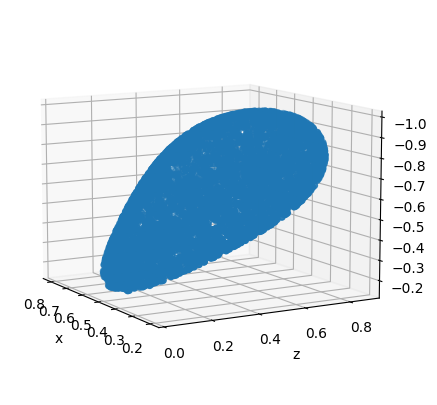

Iteration 102/500, Loss: 0.006955
Iteration 103/500, Loss: 0.006941
Iteration 104/500, Loss: 0.006885
Iteration 105/500, Loss: 0.006815
Iteration 106/500, Loss: 0.006711
Iteration 107/500, Loss: 0.006679
Iteration 108/500, Loss: 0.006637
Iteration 109/500, Loss: 0.006595
Iteration 110/500, Loss: 0.006602
Iteration 111/500, Loss: 0.006588
Iteration 112/500, Loss: 0.006516
Iteration 113/500, Loss: 0.006505
Iteration 114/500, Loss: 0.006483
Iteration 115/500, Loss: 0.006504
Iteration 116/500, Loss: 0.006437
Iteration 117/500, Loss: 0.006267
Iteration 118/500, Loss: 0.006245
Iteration 119/500, Loss: 0.006187
Iteration 120/500, Loss: 0.006223
Iteration 121/500, Loss: 0.006155
Iteration 122/500, Loss: 0.006190
Iteration 123/500, Loss: 0.006148
Iteration 124/500, Loss: 0.006116
Iteration 125/500, Loss: 0.006043
Iteration 126/500, Loss: 0.006047
Iteration 127/500, Loss: 0.006009
Iteration 128/500, Loss: 0.006030
Iteration 129/500, Loss: 0.005933
Iteration 130/500, Loss: 0.006024
Iteration 131/

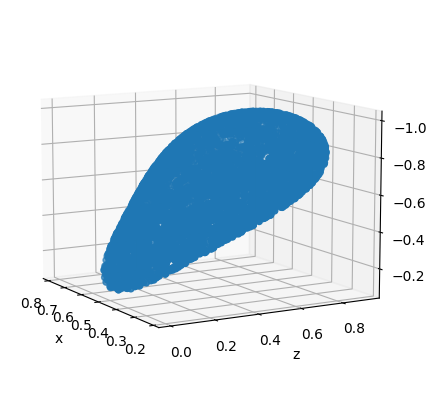

Iteration 202/500, Loss: 0.004915
Iteration 203/500, Loss: 0.004921
Iteration 204/500, Loss: 0.004893
Iteration 205/500, Loss: 0.004869
Iteration 206/500, Loss: 0.004876
Iteration 207/500, Loss: 0.004849
Iteration 208/500, Loss: 0.004823
Iteration 209/500, Loss: 0.004824
Iteration 210/500, Loss: 0.004905
Iteration 211/500, Loss: 0.004781
Iteration 212/500, Loss: 0.004834
Iteration 213/500, Loss: 0.004838
Iteration 214/500, Loss: 0.004783
Iteration 215/500, Loss: 0.004785
Iteration 216/500, Loss: 0.004798
Iteration 217/500, Loss: 0.004795
Iteration 218/500, Loss: 0.004804
Iteration 219/500, Loss: 0.004809
Iteration 220/500, Loss: 0.004756
Iteration 221/500, Loss: 0.004720
Iteration 222/500, Loss: 0.004725
Iteration 223/500, Loss: 0.004752
Iteration 224/500, Loss: 0.004793
Iteration 225/500, Loss: 0.004721
Iteration 226/500, Loss: 0.004635
Iteration 227/500, Loss: 0.004819
Iteration 228/500, Loss: 0.004760
Iteration 229/500, Loss: 0.004679
Iteration 230/500, Loss: 0.004694
Iteration 231/

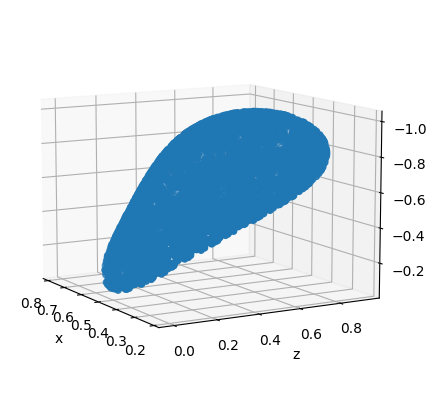

Iteration 302/500, Loss: 0.004400
Iteration 303/500, Loss: 0.004433
Iteration 304/500, Loss: 0.004368
Iteration 305/500, Loss: 0.004445
Iteration 306/500, Loss: 0.004452
Iteration 307/500, Loss: 0.004431
Iteration 308/500, Loss: 0.004432
Iteration 309/500, Loss: 0.004493
Iteration 310/500, Loss: 0.004410
Iteration 311/500, Loss: 0.004355
Iteration 312/500, Loss: 0.004381
Iteration 313/500, Loss: 0.004381
Iteration 314/500, Loss: 0.004380
Iteration 315/500, Loss: 0.004397
Iteration 316/500, Loss: 0.004448
Iteration 317/500, Loss: 0.004386
Iteration 318/500, Loss: 0.004365
Iteration 319/500, Loss: 0.004388
Iteration 320/500, Loss: 0.004334
Iteration 321/500, Loss: 0.004304
Iteration 322/500, Loss: 0.004421
Iteration 323/500, Loss: 0.004379
Iteration 324/500, Loss: 0.004348
Iteration 325/500, Loss: 0.004340
Iteration 326/500, Loss: 0.004357
Iteration 327/500, Loss: 0.004352
Iteration 328/500, Loss: 0.004317
Iteration 329/500, Loss: 0.004362
Iteration 330/500, Loss: 0.004290
Iteration 331/

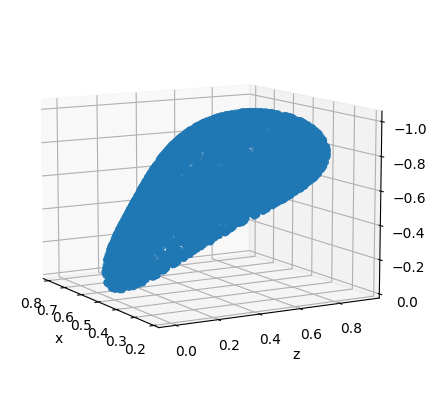

Iteration 402/500, Loss: 0.004260
Iteration 403/500, Loss: 0.004225
Iteration 404/500, Loss: 0.004197
Iteration 405/500, Loss: 0.004217
Iteration 406/500, Loss: 0.004212
Iteration 407/500, Loss: 0.004207
Iteration 408/500, Loss: 0.004204
Iteration 409/500, Loss: 0.004204
Iteration 410/500, Loss: 0.004191
Iteration 411/500, Loss: 0.004243
Iteration 412/500, Loss: 0.004148
Iteration 413/500, Loss: 0.004215
Iteration 414/500, Loss: 0.004237
Iteration 415/500, Loss: 0.004225
Iteration 416/500, Loss: 0.004220
Iteration 417/500, Loss: 0.004242
Iteration 418/500, Loss: 0.004195
Iteration 419/500, Loss: 0.004204
Iteration 420/500, Loss: 0.004210
Iteration 421/500, Loss: 0.004244
Iteration 422/500, Loss: 0.004222
Iteration 423/500, Loss: 0.004168
Iteration 424/500, Loss: 0.004182
Iteration 425/500, Loss: 0.004214
Iteration 426/500, Loss: 0.004182
Iteration 427/500, Loss: 0.004207
Iteration 428/500, Loss: 0.004162
Iteration 429/500, Loss: 0.004193
Iteration 430/500, Loss: 0.004165
Iteration 431/

In [42]:
settings = {
    'num_layers' : 3,
    'dimension' : (3,3,3), 
    'learning_rate' : 0.5,
    # Loss weights
    'w_chamfer' : 1.0,
    'w_edge' : 1.0,
    'w_normal' : 0.01,
    'w_laplacian' : 0.1,
    'print_interval' : 100,
    'num_iterations' : 500
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_03.pkl' , data)

Iteration 1/100, Loss: 0.100406


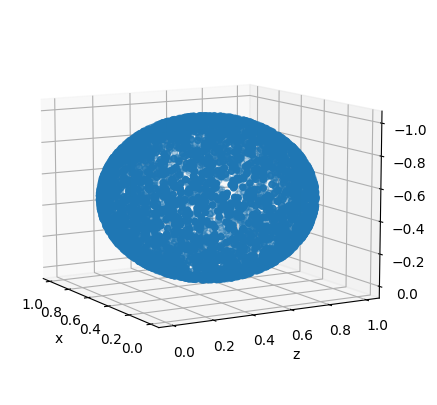

Iteration 2/100, Loss: 0.098974
Iteration 3/100, Loss: 0.097046
Iteration 4/100, Loss: 0.096728
Iteration 5/100, Loss: 0.097425
Iteration 6/100, Loss: 0.096189
Iteration 7/100, Loss: 0.093409
Iteration 8/100, Loss: 0.093000
Iteration 9/100, Loss: 0.092996
Iteration 10/100, Loss: 0.092638
Iteration 11/100, Loss: 0.091560
Iteration 12/100, Loss: 0.088623
Iteration 13/100, Loss: 0.089928
Iteration 14/100, Loss: 0.089477
Iteration 15/100, Loss: 0.087654
Iteration 16/100, Loss: 0.086151
Iteration 17/100, Loss: 0.086584
Iteration 18/100, Loss: 0.084094
Iteration 19/100, Loss: 0.084403
Iteration 20/100, Loss: 0.082720
Iteration 21/100, Loss: 0.082522
Iteration 22/100, Loss: 0.079754
Iteration 23/100, Loss: 0.080506
Iteration 24/100, Loss: 0.079532
Iteration 25/100, Loss: 0.078433
Iteration 26/100, Loss: 0.078345
Iteration 27/100, Loss: 0.077799
Iteration 28/100, Loss: 0.077020
Iteration 29/100, Loss: 0.074717
Iteration 30/100, Loss: 0.075303
Iteration 31/100, Loss: 0.073619
Iteration 32/100, 

In [43]:
settings = {
    'num_layers' : 3,
    'dimension' : (5,5,5), 
    'learning_rate' : 0.5,
    # Loss weights
    'w_chamfer' : 1.0,
    'w_edge' : 1.0,
    'w_normal' : 0.01,
    'w_laplacian' : 0.1,
    'print_interval' : 100,
    'num_iterations' : 100
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_04.pkl' , data)

Iteration 1/100, Loss: 0.101517


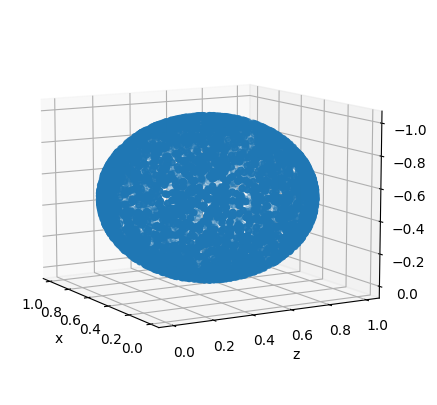

Iteration 2/100, Loss: 0.101532
Iteration 3/100, Loss: 0.098640
Iteration 4/100, Loss: 0.099208
Iteration 5/100, Loss: 0.099719
Iteration 6/100, Loss: 0.101082
Iteration 7/100, Loss: 0.100148
Iteration 8/100, Loss: 0.097491
Iteration 9/100, Loss: 0.099621
Iteration 10/100, Loss: 0.098567
Iteration 11/100, Loss: 0.099148
Iteration 12/100, Loss: 0.097849
Iteration 13/100, Loss: 0.098021
Iteration 14/100, Loss: 0.098207
Iteration 15/100, Loss: 0.096923
Iteration 16/100, Loss: 0.096707
Iteration 17/100, Loss: 0.095192
Iteration 18/100, Loss: 0.097223
Iteration 19/100, Loss: 0.095771
Iteration 20/100, Loss: 0.097715
Iteration 21/100, Loss: 0.095604
Iteration 22/100, Loss: 0.095333
Iteration 23/100, Loss: 0.096886
Iteration 24/100, Loss: 0.095887
Iteration 25/100, Loss: 0.095441
Iteration 26/100, Loss: 0.096597
Iteration 27/100, Loss: 0.095787
Iteration 28/100, Loss: 0.095512
Iteration 29/100, Loss: 0.095086
Iteration 30/100, Loss: 0.095424
Iteration 31/100, Loss: 0.093944
Iteration 32/100, 

In [44]:
settings = {
    'num_layers' : 3,
    'dimension' : (5,5,5), 
    'learning_rate' : 0.1,
    # Loss weights
    'w_chamfer' : 1.0,
    'w_edge' : 1.0,
    'w_normal' : 0.01,
    'w_laplacian' : 0.1,
    'print_interval' : 100,
    'num_iterations' : 100
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_05.pkl' , data)

Iteration 1/100, Loss: 0.099051


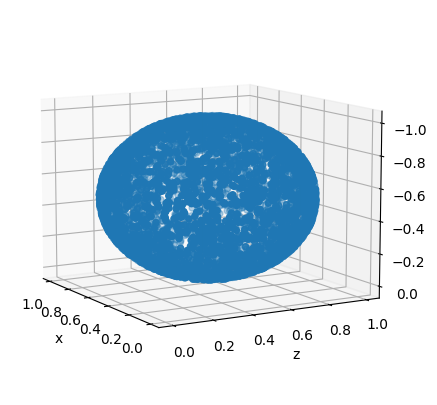

Iteration 2/100, Loss: 0.098079
Iteration 3/100, Loss: 0.099329
Iteration 4/100, Loss: 0.101763
Iteration 5/100, Loss: 0.097085
Iteration 6/100, Loss: 0.097911
Iteration 7/100, Loss: 0.097385
Iteration 8/100, Loss: 0.099215
Iteration 9/100, Loss: 0.099299
Iteration 10/100, Loss: 0.098624
Iteration 11/100, Loss: 0.097950
Iteration 12/100, Loss: 0.099312
Iteration 13/100, Loss: 0.098203
Iteration 14/100, Loss: 0.098572
Iteration 15/100, Loss: 0.096407
Iteration 16/100, Loss: 0.096438
Iteration 17/100, Loss: 0.097502
Iteration 18/100, Loss: 0.096477
Iteration 19/100, Loss: 0.097224
Iteration 20/100, Loss: 0.097807
Iteration 21/100, Loss: 0.097181
Iteration 22/100, Loss: 0.095369
Iteration 23/100, Loss: 0.094908
Iteration 24/100, Loss: 0.095658
Iteration 25/100, Loss: 0.094489
Iteration 26/100, Loss: 0.095823
Iteration 27/100, Loss: 0.094973
Iteration 28/100, Loss: 0.094493
Iteration 29/100, Loss: 0.093799
Iteration 30/100, Loss: 0.094324
Iteration 31/100, Loss: 0.094818
Iteration 32/100, 

In [ ]:
settings = {
    'num_layers' : 3,
    'dimension' : (5,5,5), 
    'learning_rate' : 0.1,
    # Loss weights
    'w_chamfer' : 1.0,
    'w_edge' : 0.5,
    'w_normal' : 0.1,
    'w_laplacian' : 0.1,
    'print_interval' : 100,
    'num_iterations' : 100
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_06.pkl' , data)

## Carregamento dos resultados

In [44]:
load1 = load_training_data("./treino_01.pkl")
load2 = load_training_data("./treino_02.pkl")
load3 = load_training_data("./treino_03.pkl")
load4 = load_training_data("./treino_04.pkl")
load5 = load_training_data("./treino_05.pkl")
# load5 = load_training_data("./treino_06.pkl")

Dados carregados de ./treino_01.pkl
Dados carregados de ./treino_02.pkl
Dados carregados de ./treino_03.pkl
Dados carregados de ./treino_04.pkl
Dados carregados de ./treino_05.pkl


## PLOTS

### Plot dos deltas

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_control_points(control_points, control_points_delta):
    """
    Plota os pontos de controle antes e depois dos deslocamentos, conectando-os com linhas.
    """
    # Calcula os pontos de controle deslocados
    deformed_control_points = control_points + control_points_delta

    # Cria um gráfico 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Extrai os pontos originais e deslocados em listas separadas para facilitar o plot
    original_x, original_y, original_z = control_points[..., 0].flatten(), control_points[..., 1].flatten(), control_points[..., 2].flatten()
    deformed_x, deformed_y, deformed_z = deformed_control_points[..., 0].flatten(), deformed_control_points[..., 1].flatten(), deformed_control_points[..., 2].flatten()

    # Plotando os pontos de controle originais
    ax.scatter(original_x, original_y, original_z, color='blue', label='Pontos de Controle Originais')
    
    # Plotando os pontos de controle deslocados
    ax.scatter(deformed_x, deformed_y, deformed_z, color='red', label='Pontos de Controle Deslocados')

    # Conectando cada ponto de controle original ao seu ponto deslocado com linhas verdes
    for i in range(len(original_x)):
        ax.plot([original_x[i], deformed_x[i]], 
                [original_y[i], deformed_y[i]], 
                [original_z[i], deformed_z[i]], 
                color='green', linestyle='--', linewidth=1)

    # Ajustes no gráfico
    ax.set_title("Pontos de Controle e Seus Deslocamentos Após Treinamento")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    
    plt.show()

# # Plotando após o treinamento
# plot_control_points(torch.tensor([[[[i/(l-1), j/(m-1), k/(n-1)] for k in range(n)] for j in range(m)] for i in range(l)]).detach().numpy(), control_points_delta.detach().numpy())


In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

def plot_control_points_with_mesh(control_points, control_points_delta, mesh):
    """
    Plota os pontos de controle antes e depois dos deslocamentos, conectando-os com linhas,
    e adiciona a malha original com transparência.
    
    Args:
        control_points: tensor com os pontos de controle originais (l, m, n, 3).
        control_points_delta: tensor com os deslocamentos dos pontos de controle (l, m, n, 3).
        mesh: instância de Meshes do pytorch3d representando a malha original.
    """
    # Calcula os pontos de controle deslocados
    deformed_control_points = control_points + control_points_delta

    # Cria um gráfico 3D
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Extrai os pontos originais e deslocados em listas separadas para facilitar o plot
    original_x, original_y, original_z = control_points[..., 0].flatten(), control_points[..., 1].flatten(), control_points[..., 2].flatten()
    deformed_x, deformed_y, deformed_z = deformed_control_points[..., 0].flatten(), deformed_control_points[..., 1].flatten(), deformed_control_points[..., 2].flatten()

    # Plotando os pontos de controle originais
    ax.scatter(original_x, original_y, original_z, color='blue', label='Pontos de Controle Originais')
    
    # Plotando os pontos de controle deslocados
    ax.scatter(deformed_x, deformed_y, deformed_z, color='red', label='Pontos de Controle Deslocados')

    # Conectando cada ponto de controle original ao seu ponto deslocado com linhas verdes
    for i in range(len(original_x)):
        ax.plot([original_x[i], deformed_x[i]], 
                [original_y[i], deformed_y[i]], 
                [original_z[i], deformed_z[i]], 
                color='green', linestyle='--', linewidth=1)

    # Plotando a malha original com transparência
    verts_np = mesh.verts_packed().detach().cpu().numpy()  # Vértices da malha convertidos para numpy
    faces_np = mesh.faces_packed().detach().cpu().numpy()  # Faces da malha convertidas para numpy

    mesh_poly = Poly3DCollection(verts_np[faces_np], alpha=0.3, facecolor='gray', edgecolor='none')
    ax.add_collection3d(mesh_poly)

    # Ajustes no gráfico
    ax.set_title("Pontos de Controle, Seus Deslocamentos e Malha Original")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    
    plt.show()

# Exemplo de chamada para plotar com a malha original
for load in [load1, load2, load3, load4, load5]:
    l, m, n = load['params']['dimension']
    final_mesh = load['final_mesh']
    deltas = load['deltas'][-1]
    err_list = load['err_list']
    
    control_points = [[[[i/(l-1), j/(m-1), k/(n-1)] for k in range(n)] for j in range(m)] for i in range(l)]
    plot_control_points_with_mesh(torch.tensor(control_points).reshape(l*m*n,3), deltas.detach(), final_mesh)

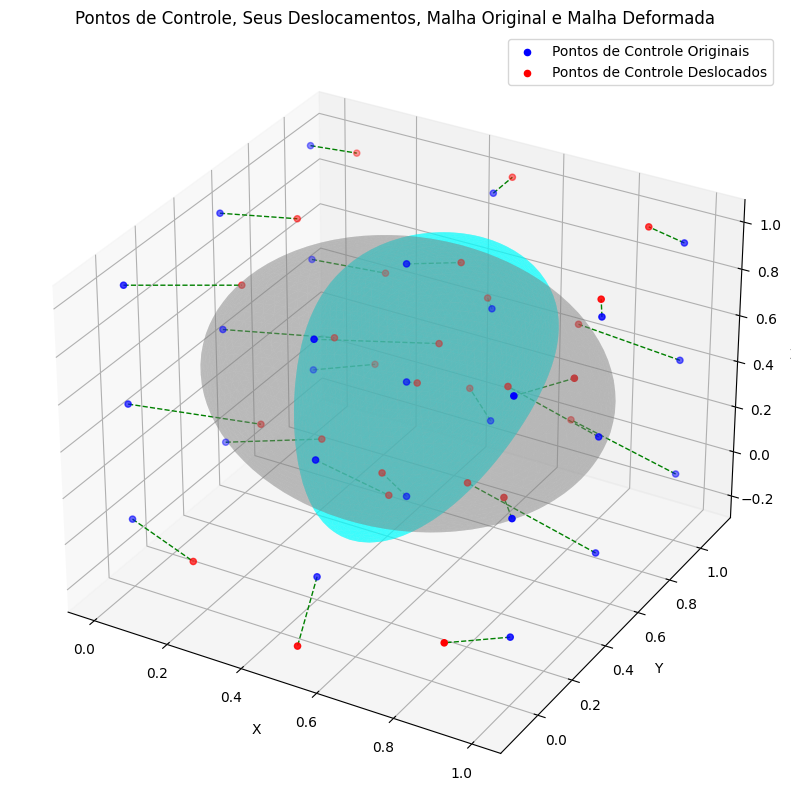

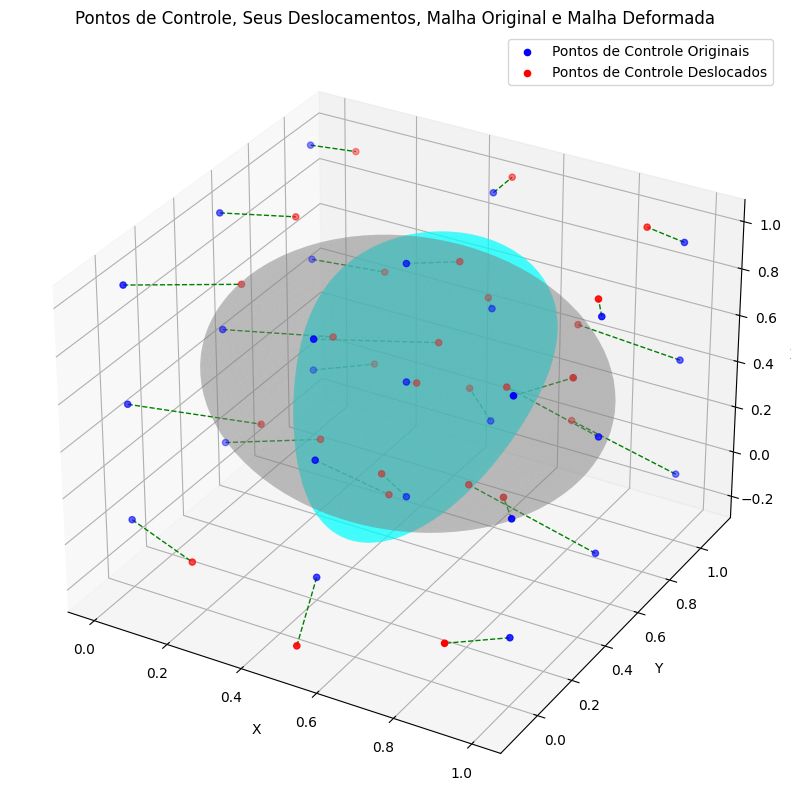

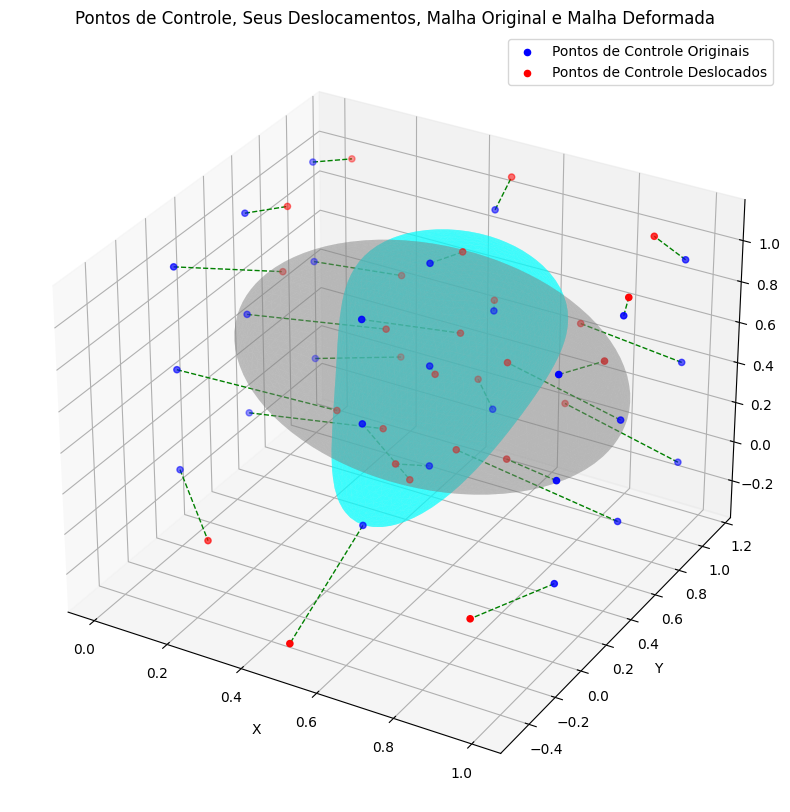

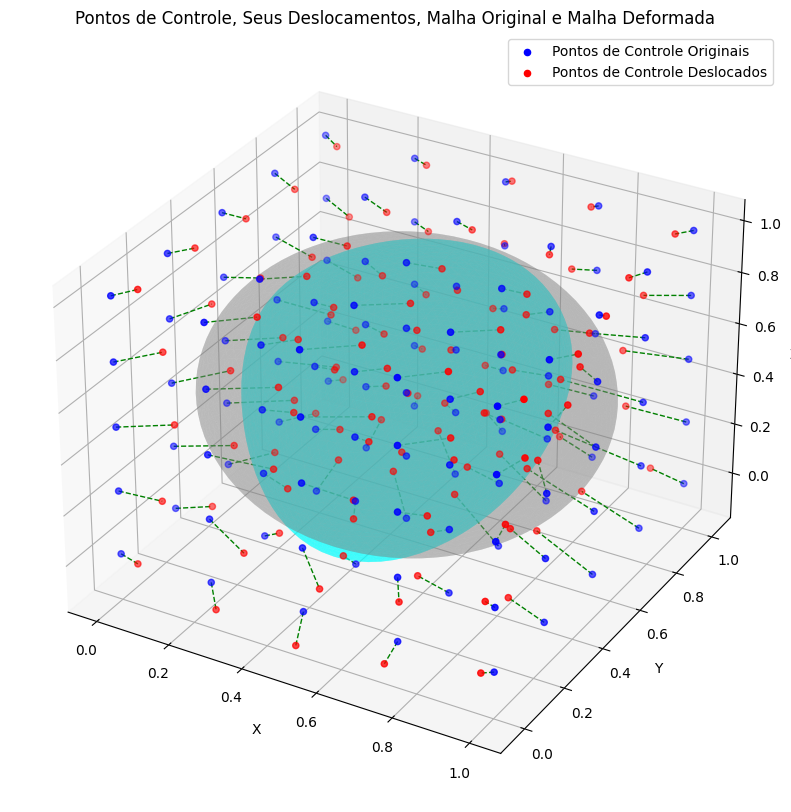

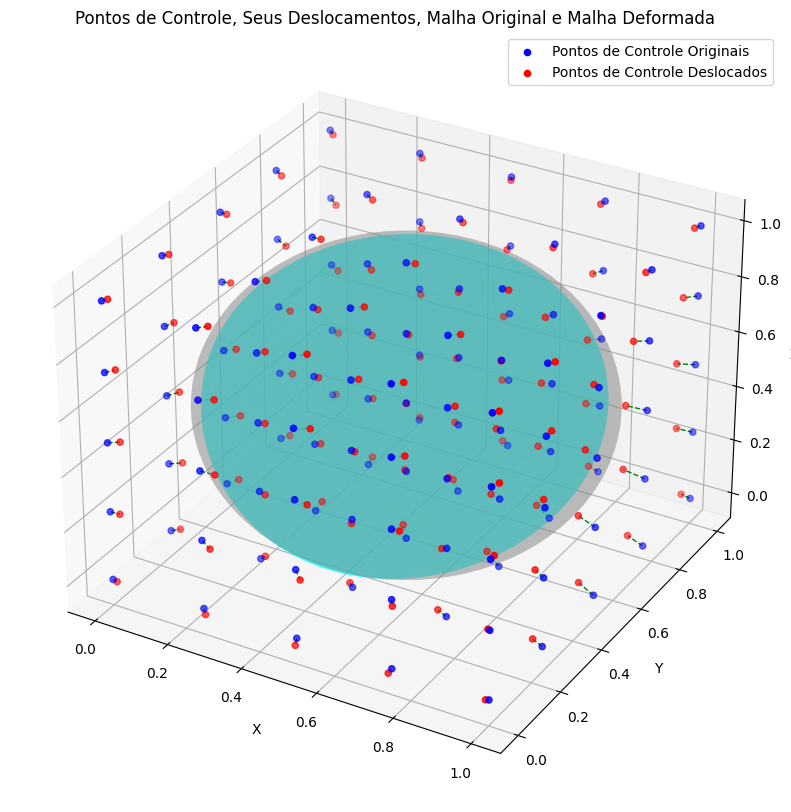

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from pytorch3d.structures import Meshes

def plot_control_points_with_meshes(control_points, control_points_delta, mesh, deformed_mesh):
    """
    Plota os pontos de controle antes e depois dos deslocamentos, conectando-os com linhas,
    adiciona a malha original com transparência e a malha deformada.
    
    Args:
        control_points: tensor com os pontos de controle originais (l, m, n, 3).
        control_points_delta: tensor com os deslocamentos dos pontos de controle (l, m, n, 3).
        mesh: instância de Meshes do pytorch3d representando a malha original.
        deformed_mesh: instância de Meshes do pytorch3d representando a malha deformada.
    """
    # Calcula os pontos de controle deslocados
    deformed_control_points = control_points + control_points_delta

    # Cria um gráfico 3D
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Extrai os pontos originais e deslocados em listas separadas para facilitar o plot
    original_x, original_y, original_z = control_points[..., 0].flatten(), control_points[..., 1].flatten(), control_points[..., 2].flatten()
    deformed_x, deformed_y, deformed_z = deformed_control_points[..., 0].flatten(), deformed_control_points[..., 1].flatten(), deformed_control_points[..., 2].flatten()

    # Plotando os pontos de controle originais
    ax.scatter(original_x, original_y, original_z, color='blue', label='Pontos de Controle Originais')
    
    # Plotando os pontos de controle deslocados
    ax.scatter(deformed_x, deformed_y, deformed_z, color='red', label='Pontos de Controle Deslocados')

    # Conectando cada ponto de controle original ao seu ponto deslocado com linhas verdes
    for i in range(len(original_x)):
        ax.plot([original_x[i], deformed_x[i]], 
                [original_y[i], deformed_y[i]], 
                [original_z[i], deformed_z[i]], 
                color='green', linestyle='--', linewidth=1)

    # Plotando a malha original com transparência
    verts_np = mesh.verts_packed().detach().cpu().numpy()  # Vértices da malha convertidos para numpy
    faces_np = mesh.faces_packed().detach().cpu().numpy()  # Faces da malha convertidas para numpy

    mesh_poly = Poly3DCollection(verts_np[faces_np], alpha=0.3, facecolor='gray', edgecolor='none')
    ax.add_collection3d(mesh_poly)

    # Plotando a malha deformada com cores diferentes para contraste
    deformed_verts_np = deformed_mesh.verts_packed().detach().cpu().numpy()  # Vértices deformados da malha
    deformed_faces_np = deformed_mesh.faces_packed().detach().cpu().numpy()  # Faces deformadas da malha

    deformed_mesh_poly = Poly3DCollection(deformed_verts_np[deformed_faces_np], alpha=0.5, facecolor='cyan', edgecolor='none')
    ax.add_collection3d(deformed_mesh_poly)

    # Ajustes no gráfico
    ax.set_title("Pontos de Controle, Seus Deslocamentos, Malha Original e Malha Deformada")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    
    plt.show()

src_mesh = ico_sphere(4)

for load in [load1, load2, load3, load4, load5]:
    l, m, n = load['params']['dimension']
    final_mesh = load['final_mesh']
    deltas = load['deltas'][-1]
    err_list = load['err_list']
    
    control_points = [[[[i/(l-1), j/(m-1), k/(n-1)] for k in range(n)] for j in range(m)] for i in range(l)]
    plot_control_points_with_meshes(torch.tensor(control_points).reshape(l*m*n,3), deltas.detach(), 
src_mesh.scale_verts(0.5).offset_verts(torch.tensor([0.5,0.5,0.5])), final_mesh)

### Plot dos erros

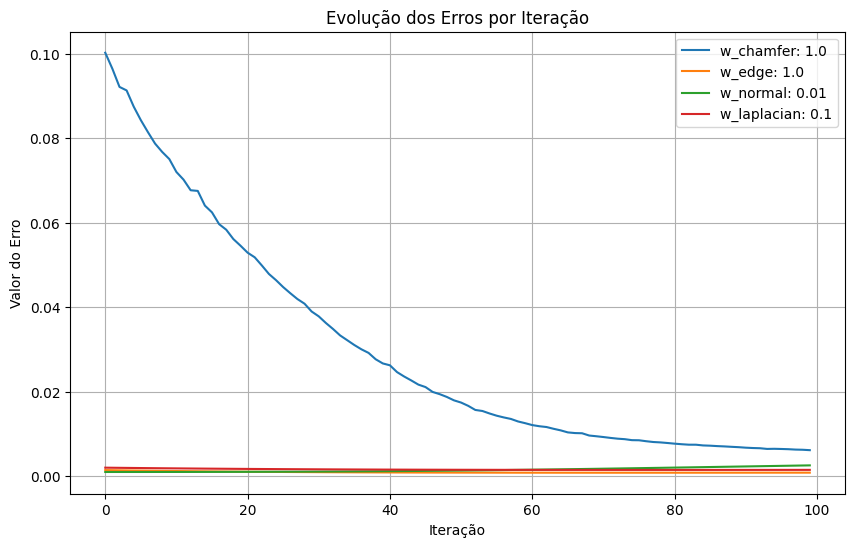

{'num_layers': 3, 'dimension': (3, 3, 3), 'learning_rate': 0.5, 'w_chamfer': 1.0, 'w_edge': 1.0, 'w_normal': 0.01, 'w_laplacian': 0.1, 'print_interval': 100, 'num_iterations': 100}


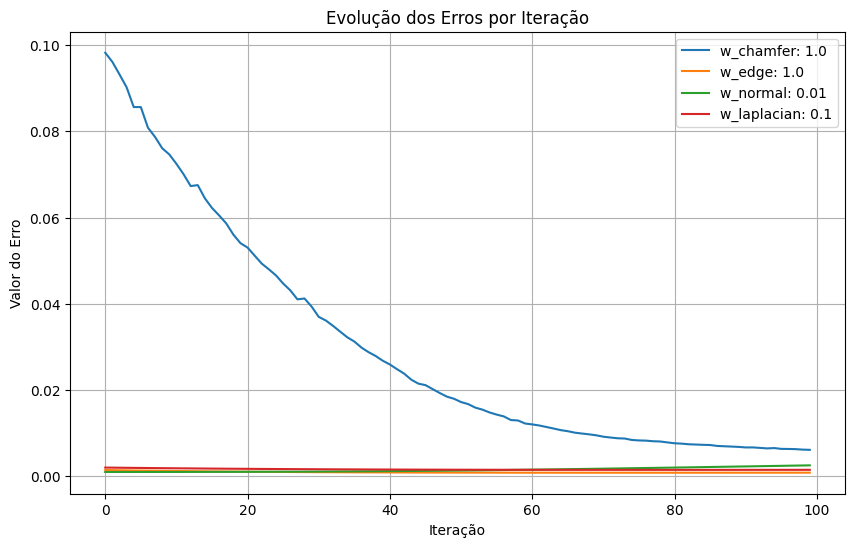

{'num_layers': 1, 'dimension': (3, 3, 3), 'learning_rate': 0.5, 'w_chamfer': 1.0, 'w_edge': 1.0, 'w_normal': 0.01, 'w_laplacian': 0.1, 'print_interval': 100, 'num_iterations': 100}


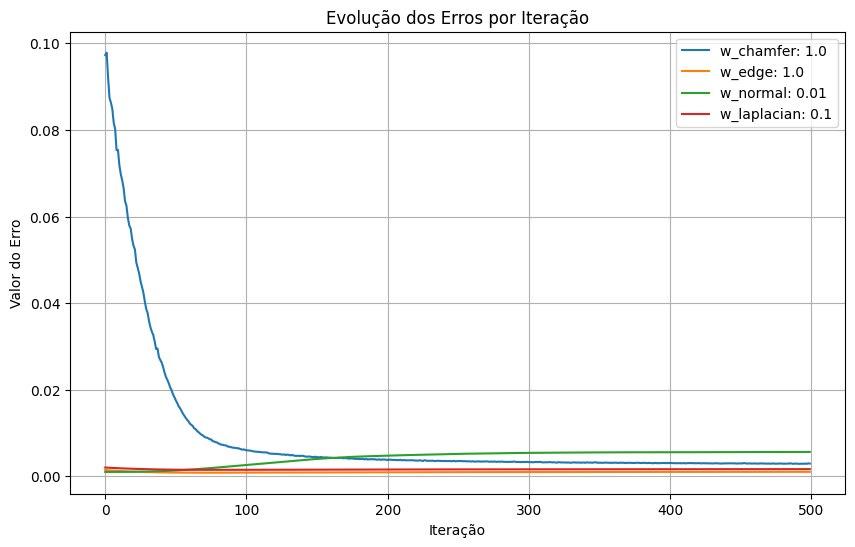

{'num_layers': 3, 'dimension': (3, 3, 3), 'learning_rate': 0.5, 'w_chamfer': 1.0, 'w_edge': 1.0, 'w_normal': 0.01, 'w_laplacian': 0.1, 'print_interval': 100, 'num_iterations': 500}


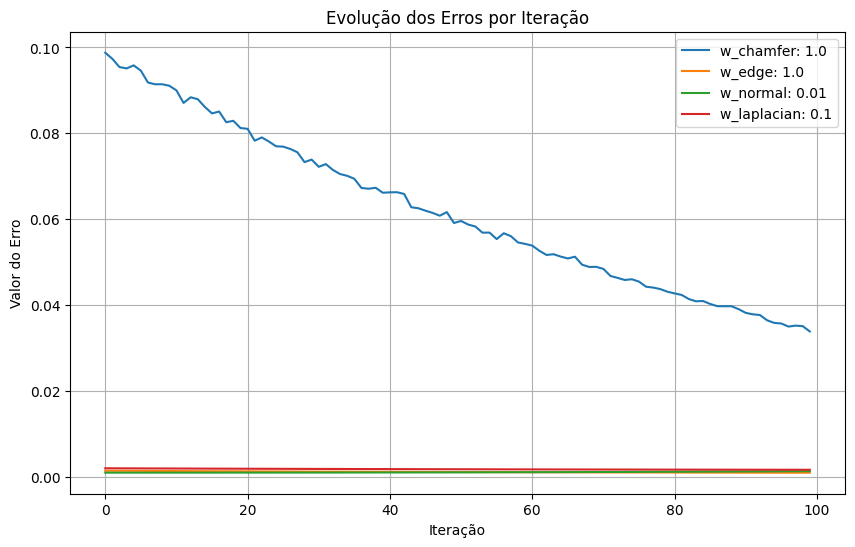

{'num_layers': 3, 'dimension': (5, 5, 5), 'learning_rate': 0.5, 'w_chamfer': 1.0, 'w_edge': 1.0, 'w_normal': 0.01, 'w_laplacian': 0.1, 'print_interval': 100, 'num_iterations': 100}


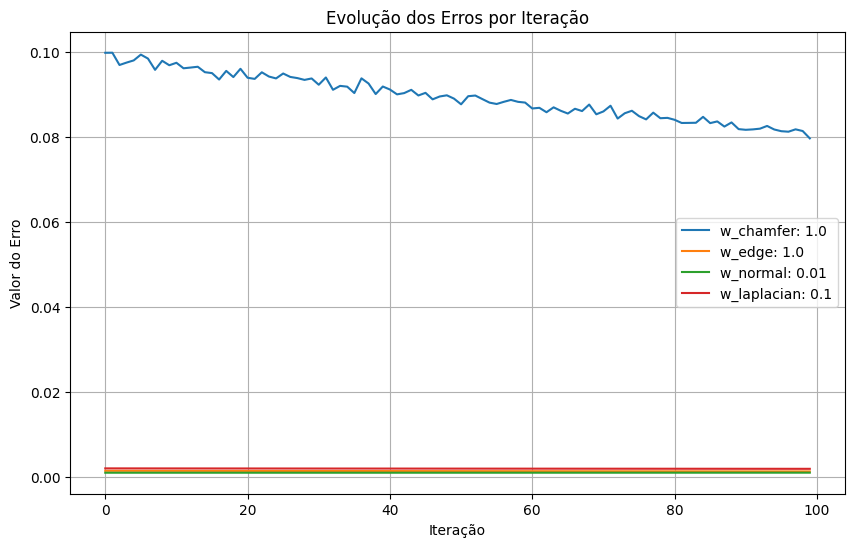

{'num_layers': 3, 'dimension': (5, 5, 5), 'learning_rate': 0.1, 'w_chamfer': 1.0, 'w_edge': 1.0, 'w_normal': 0.01, 'w_laplacian': 0.1, 'print_interval': 100, 'num_iterations': 100}


In [128]:
for load in [load1, load2, load3, load4, load5]:
    err_list = load['err_list']
    y = lambda x: x.detach().numpy() 
    erros_tratados = np.array([[float(y(x)) for x in xx] for xx in err_list])

    iteracoes = np.arange(len(erros_tratados))  # [0, 1, 2, ..., 99]
    # Configurar o gráfico
    plt.figure(figsize=(10, 6))
    plt.title("Evolução dos Erros por Iteração")
    plt.xlabel("Iteração")
    plt.ylabel("Valor do Erro")

    legenda_erros = ['w_chamfer', 'w_edge', 'w_normal', 'w_laplacian']
    # Plotar cada erro (4 no total)
    for i in range(erros_tratados.shape[1]):  # Itera sobre as 4 colunas
        plt.plot(iteracoes, erros_tratados[:, i], label=f"{legenda_erros[i]}: {load.get('params').get(legenda_erros[i])}")
        
    
    # Adicionar legendas e exibir o gráfico
    plt.legend()
    plt.grid(True)
    plt.show()
    print(load.get('params'))


## Outros testes

Iteration 1/160, Loss: 0.051864


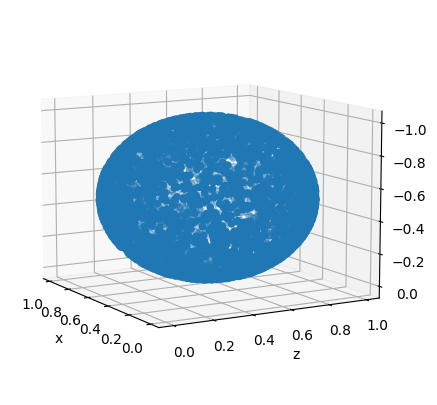

Iteration 2/160, Loss: 0.052224
Iteration 3/160, Loss: 0.050905
Iteration 4/160, Loss: 0.050655
Iteration 5/160, Loss: 0.049825
Iteration 6/160, Loss: 0.048875
Iteration 7/160, Loss: 0.048558
Iteration 8/160, Loss: 0.047046
Iteration 9/160, Loss: 0.047815
Iteration 10/160, Loss: 0.045895
Iteration 11/160, Loss: 0.044956
Iteration 12/160, Loss: 0.045121
Iteration 13/160, Loss: 0.044085
Iteration 14/160, Loss: 0.043538
Iteration 15/160, Loss: 0.042419
Iteration 16/160, Loss: 0.041707
Iteration 17/160, Loss: 0.041855
Iteration 18/160, Loss: 0.040018
Iteration 19/160, Loss: 0.040167
Iteration 20/160, Loss: 0.039772
Iteration 21/160, Loss: 0.038429


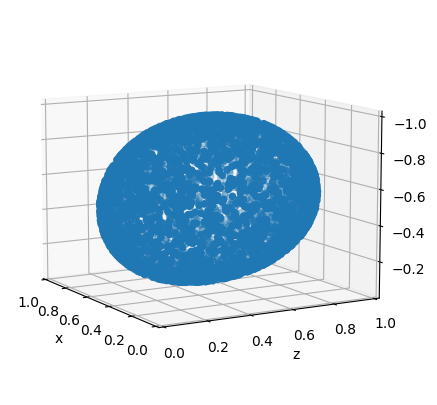

Iteration 22/160, Loss: 0.038945
Iteration 23/160, Loss: 0.037994
Iteration 24/160, Loss: 0.037141
Iteration 25/160, Loss: 0.036673
Iteration 26/160, Loss: 0.035319
Iteration 27/160, Loss: 0.035675
Iteration 28/160, Loss: 0.035360
Iteration 29/160, Loss: 0.034068
Iteration 30/160, Loss: 0.034274
Iteration 31/160, Loss: 0.033188
Iteration 32/160, Loss: 0.033352
Iteration 33/160, Loss: 0.032968
Iteration 34/160, Loss: 0.031984
Iteration 35/160, Loss: 0.031248
Iteration 36/160, Loss: 0.030765
Iteration 37/160, Loss: 0.030365
Iteration 38/160, Loss: 0.030317
Iteration 39/160, Loss: 0.029880
Iteration 40/160, Loss: 0.029507
Iteration 41/160, Loss: 0.028820


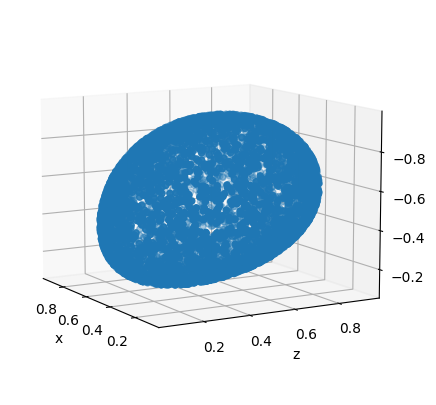

Iteration 42/160, Loss: 0.028311
Iteration 43/160, Loss: 0.028083
Iteration 44/160, Loss: 0.027638
Iteration 45/160, Loss: 0.027056
Iteration 46/160, Loss: 0.026608
Iteration 47/160, Loss: 0.026330
Iteration 48/160, Loss: 0.025961
Iteration 49/160, Loss: 0.025566
Iteration 50/160, Loss: 0.025065
Iteration 51/160, Loss: 0.024879
Iteration 52/160, Loss: 0.024197
Iteration 53/160, Loss: 0.023924
Iteration 54/160, Loss: 0.023676
Iteration 55/160, Loss: 0.023091
Iteration 56/160, Loss: 0.022880
Iteration 57/160, Loss: 0.022475
Iteration 58/160, Loss: 0.021919
Iteration 59/160, Loss: 0.021696
Iteration 60/160, Loss: 0.021195
Iteration 61/160, Loss: 0.021055


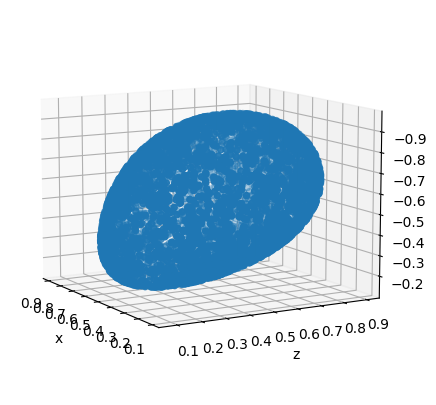

Iteration 62/160, Loss: 0.020480
Iteration 63/160, Loss: 0.020579
Iteration 64/160, Loss: 0.020146
Iteration 65/160, Loss: 0.019462
Iteration 66/160, Loss: 0.019195
Iteration 67/160, Loss: 0.018883
Iteration 68/160, Loss: 0.018796
Iteration 69/160, Loss: 0.018531
Iteration 70/160, Loss: 0.018063
Iteration 71/160, Loss: 0.017775
Iteration 72/160, Loss: 0.017357
Iteration 73/160, Loss: 0.017370
Iteration 74/160, Loss: 0.017109
Iteration 75/160, Loss: 0.016517
Iteration 76/160, Loss: 0.016438
Iteration 77/160, Loss: 0.016071
Iteration 78/160, Loss: 0.015948
Iteration 79/160, Loss: 0.015784
Iteration 80/160, Loss: 0.015298
Iteration 81/160, Loss: 0.014994


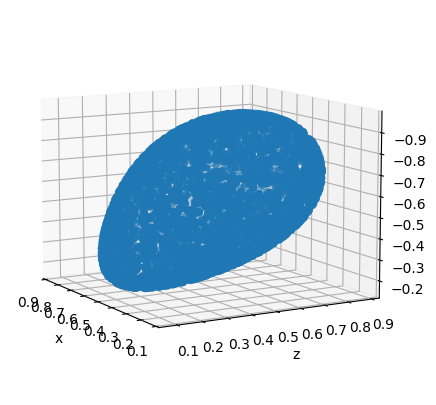

Iteration 82/160, Loss: 0.014748
Iteration 83/160, Loss: 0.014681
Iteration 84/160, Loss: 0.014414
Iteration 85/160, Loss: 0.014138
Iteration 86/160, Loss: 0.013903
Iteration 87/160, Loss: 0.013582
Iteration 88/160, Loss: 0.013340
Iteration 89/160, Loss: 0.013149
Iteration 90/160, Loss: 0.012993
Iteration 91/160, Loss: 0.012845
Iteration 92/160, Loss: 0.012783
Iteration 93/160, Loss: 0.012326
Iteration 94/160, Loss: 0.012132
Iteration 95/160, Loss: 0.011915
Iteration 96/160, Loss: 0.011857
Iteration 97/160, Loss: 0.011583
Iteration 98/160, Loss: 0.011430
Iteration 99/160, Loss: 0.011181
Iteration 100/160, Loss: 0.011000
Iteration 101/160, Loss: 0.010865


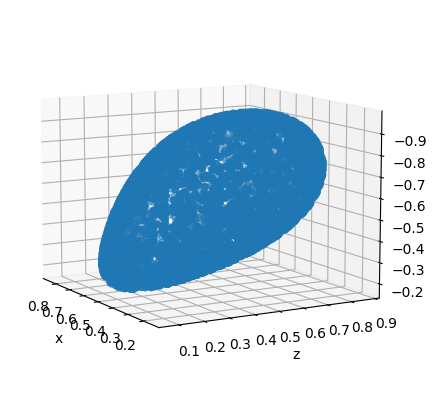

Iteration 102/160, Loss: 0.010631
Iteration 103/160, Loss: 0.010499
Iteration 104/160, Loss: 0.010463
Iteration 105/160, Loss: 0.010205
Iteration 106/160, Loss: 0.010161
Iteration 107/160, Loss: 0.010008
Iteration 108/160, Loss: 0.009771
Iteration 109/160, Loss: 0.009672
Iteration 110/160, Loss: 0.009557
Iteration 111/160, Loss: 0.009407
Iteration 112/160, Loss: 0.009188
Iteration 113/160, Loss: 0.009125
Iteration 114/160, Loss: 0.009025
Iteration 115/160, Loss: 0.008906
Iteration 116/160, Loss: 0.008787
Iteration 117/160, Loss: 0.008698
Iteration 118/160, Loss: 0.008532
Iteration 119/160, Loss: 0.008516
Iteration 120/160, Loss: 0.008324
Iteration 121/160, Loss: 0.008216


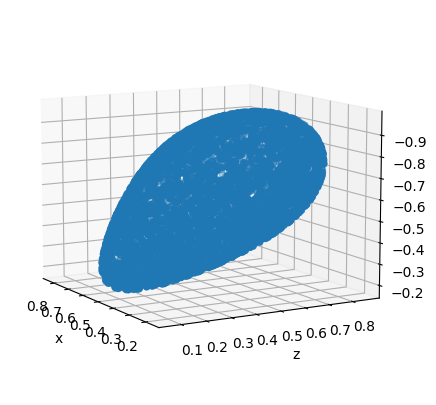

Iteration 122/160, Loss: 0.008167
Iteration 123/160, Loss: 0.008077
Iteration 124/160, Loss: 0.007985
Iteration 125/160, Loss: 0.007977
Iteration 126/160, Loss: 0.007693
Iteration 127/160, Loss: 0.007742
Iteration 128/160, Loss: 0.007670
Iteration 129/160, Loss: 0.007528
Iteration 130/160, Loss: 0.007481
Iteration 131/160, Loss: 0.007393
Iteration 132/160, Loss: 0.007339
Iteration 133/160, Loss: 0.007342
Iteration 134/160, Loss: 0.007199
Iteration 135/160, Loss: 0.007172
Iteration 136/160, Loss: 0.007141
Iteration 137/160, Loss: 0.007074
Iteration 138/160, Loss: 0.007021
Iteration 139/160, Loss: 0.006949
Iteration 140/160, Loss: 0.006906
Iteration 141/160, Loss: 0.006853


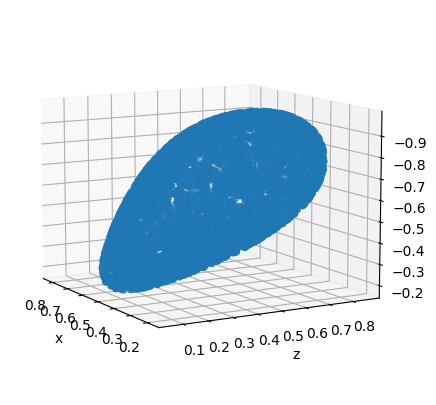

Iteration 142/160, Loss: 0.006815
Iteration 143/160, Loss: 0.006777
Iteration 144/160, Loss: 0.006711
Iteration 145/160, Loss: 0.006701
Iteration 146/160, Loss: 0.006577
Iteration 147/160, Loss: 0.006522
Iteration 148/160, Loss: 0.006529
Iteration 149/160, Loss: 0.006455
Iteration 150/160, Loss: 0.006375
Iteration 151/160, Loss: 0.006345
Iteration 152/160, Loss: 0.006316
Iteration 153/160, Loss: 0.006307
Iteration 154/160, Loss: 0.006296
Iteration 155/160, Loss: 0.006298
Iteration 156/160, Loss: 0.006187
Iteration 157/160, Loss: 0.006211
Iteration 158/160, Loss: 0.006196
Iteration 159/160, Loss: 0.006096
Iteration 160/160, Loss: 0.006057
Dados salvos em ./treino_07.pkl


In [129]:
settings = {
    'num_layers' : 1,
    'dimension' : (3,3,3), 
    'learning_rate' : 0.5,
    # Loss weights
    'w_chamfer' : 0.5,
    'w_edge' : 1.0,
    'w_normal' : 0.01,
    'w_laplacian' : 1.0,
    'print_interval' : 20,
    'num_iterations' : 160
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_07.pkl' , data)

tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 1/160, Loss: 0.052896


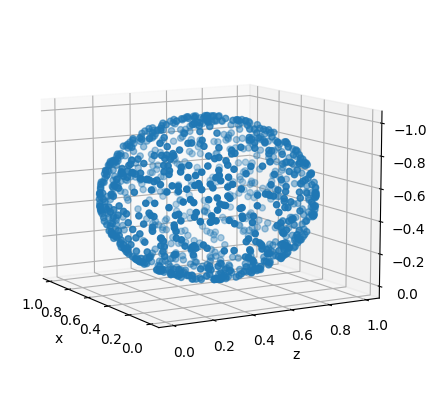

tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 2/160, Loss: 0.051971
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 3/160, Loss: 0.051063
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 4/160, Loss: 0.050172
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 5/160, Loss: 0.049297
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 6/160, Loss: 0.048439
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 7/160, Loss: 0.047599
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 8/160, Loss: 0.046777
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 9/160, Loss: 0.045973
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 10/160, Loss: 0.045183
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 11/160, Loss: 0.044409
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 12/160, Loss: 0.043650
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 13/160, Loss: 0.042905
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 14/160, Loss: 0.042175
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 15/160, Loss: 0.041459
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 16/160, Loss: 0.040756
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 17/160, Loss: 0.040065
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 18/160, Loss: 0.039388
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 19/160, Loss: 0.038724
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 20/160, Loss: 0.038076
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 21/160, Loss: 0.037440


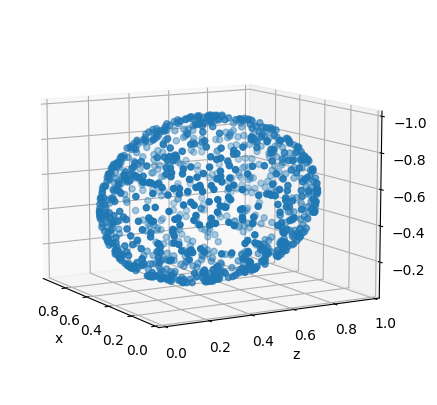

tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 22/160, Loss: 0.036819
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 23/160, Loss: 0.036208
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 24/160, Loss: 0.035609
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 25/160, Loss: 0.035022
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 26/160, Loss: 0.034448
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 27/160, Loss: 0.033883
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 28/160, Loss: 0.033328
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 29/160, Loss: 0.032784
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 30/160, Loss: 0.032251
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 31/160, Loss: 0.031728
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 32/160, Loss: 0.031216
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 33/160, Loss: 0.030714
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 34/160, Loss: 0.030221
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 35/160, Loss: 0.029736
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 36/160, Loss: 0.029261
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 37/160, Loss: 0.028795
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 38/160, Loss: 0.028336
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 39/160, Loss: 0.027879
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 40/160, Loss: 0.027428
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 41/160, Loss: 0.026982


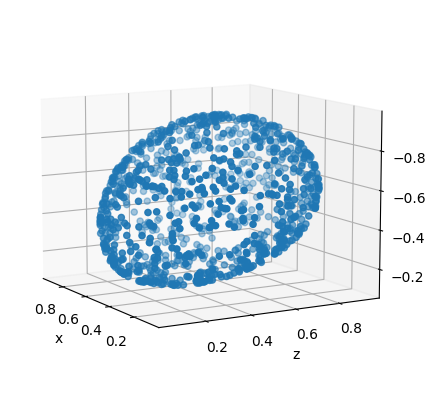

tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 42/160, Loss: 0.026542
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 43/160, Loss: 0.026104
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 44/160, Loss: 0.025673
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 45/160, Loss: 0.025250
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 46/160, Loss: 0.024831
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 47/160, Loss: 0.024416
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 48/160, Loss: 0.024007
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 49/160, Loss: 0.023602
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 50/160, Loss: 0.023201
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 51/160, Loss: 0.022806
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 52/160, Loss: 0.022416
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 53/160, Loss: 0.022033
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 54/160, Loss: 0.021656
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 55/160, Loss: 0.021284
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 56/160, Loss: 0.020917
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 57/160, Loss: 0.020557
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 58/160, Loss: 0.020203
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 59/160, Loss: 0.019855
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 60/160, Loss: 0.019511
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 61/160, Loss: 0.019171


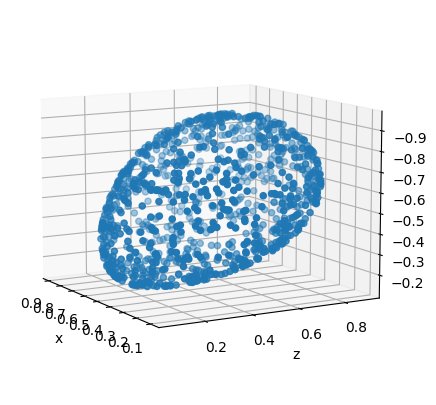

tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 62/160, Loss: 0.018837
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 63/160, Loss: 0.018509
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 64/160, Loss: 0.018186
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 65/160, Loss: 0.017867
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 66/160, Loss: 0.017555
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 67/160, Loss: 0.017246
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 68/160, Loss: 0.016944
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 69/160, Loss: 0.016647
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 70/160, Loss: 0.016356
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 71/160, Loss: 0.016068
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 72/160, Loss: 0.015785
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 73/160, Loss: 0.015504
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 74/160, Loss: 0.015229
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 75/160, Loss: 0.014959
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 76/160, Loss: 0.014695
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 77/160, Loss: 0.014436
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 78/160, Loss: 0.014182
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 79/160, Loss: 0.013933
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 80/160, Loss: 0.013687
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 81/160, Loss: 0.013447


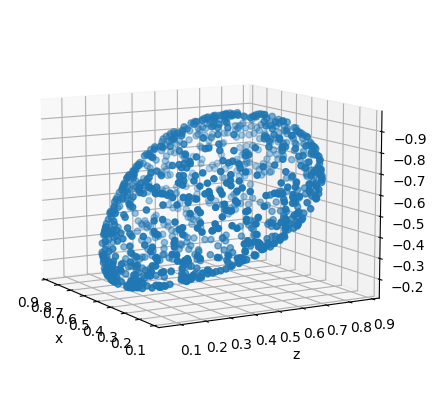

tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 82/160, Loss: 0.013210
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 83/160, Loss: 0.012979
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 84/160, Loss: 0.012751
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 85/160, Loss: 0.012526
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 86/160, Loss: 0.012309
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 87/160, Loss: 0.012097
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 88/160, Loss: 0.011889
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 89/160, Loss: 0.011685
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 90/160, Loss: 0.011485
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 91/160, Loss: 0.011289
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 92/160, Loss: 0.011097
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 93/160, Loss: 0.010909
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 94/160, Loss: 0.010724
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 95/160, Loss: 0.010543
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 96/160, Loss: 0.010366
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 97/160, Loss: 0.010193
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 98/160, Loss: 0.010024
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 99/160, Loss: 0.009858
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 100/160, Loss: 0.009696
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 101/160, Loss: 0.009538


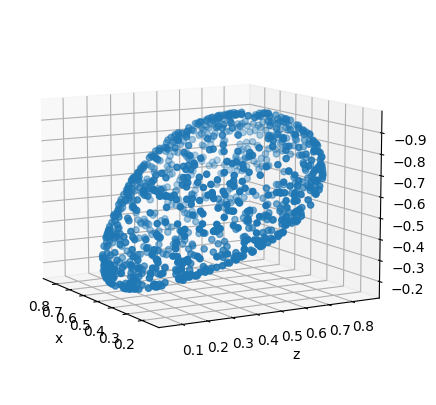

tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 102/160, Loss: 0.009382
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 103/160, Loss: 0.009231
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 104/160, Loss: 0.009083
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 105/160, Loss: 0.008939
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 106/160, Loss: 0.008796
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 107/160, Loss: 0.008657
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 108/160, Loss: 0.008520
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 109/160, Loss: 0.008386
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 110/160, Loss: 0.008256
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 111/160, Loss: 0.008130
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 112/160, Loss: 0.008005
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 113/160, Loss: 0.007883
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 114/160, Loss: 0.007764
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 115/160, Loss: 0.007648
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 116/160, Loss: 0.007535
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 117/160, Loss: 0.007424
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 118/160, Loss: 0.007316
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 119/160, Loss: 0.007211
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 120/160, Loss: 0.007110
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 121/160, Loss: 0.007011


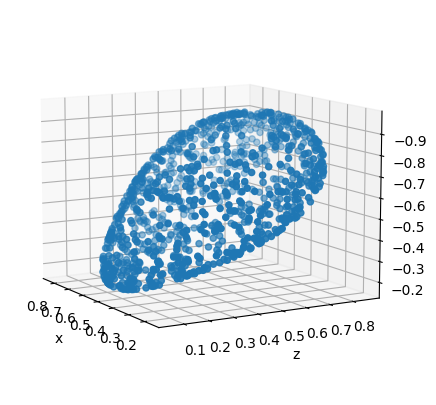

tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 122/160, Loss: 0.006915
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 123/160, Loss: 0.006821
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 124/160, Loss: 0.006729
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 125/160, Loss: 0.006639
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 126/160, Loss: 0.006551
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 127/160, Loss: 0.006466
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 128/160, Loss: 0.006382
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 129/160, Loss: 0.006301
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 130/160, Loss: 0.006223
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 131/160, Loss: 0.006146
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 132/160, Loss: 0.006071
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 133/160, Loss: 0.005998
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 134/160, Loss: 0.005928
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 135/160, Loss: 0.005859
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 136/160, Loss: 0.005792
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 137/160, Loss: 0.005727
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 138/160, Loss: 0.005664
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 139/160, Loss: 0.005603
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 140/160, Loss: 0.005543
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 141/160, Loss: 0.005486


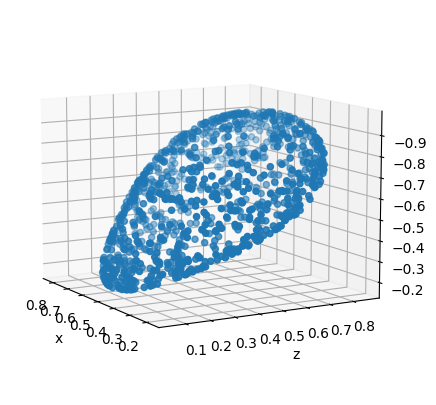

tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 142/160, Loss: 0.005429
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 143/160, Loss: 0.005375
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 144/160, Loss: 0.005322
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 145/160, Loss: 0.005270
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 146/160, Loss: 0.005219
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 147/160, Loss: 0.005169
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 148/160, Loss: 0.005121
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 149/160, Loss: 0.005074
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 150/160, Loss: 0.005028
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 151/160, Loss: 0.004983
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 152/160, Loss: 0.004938
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 153/160, Loss: 0.004895
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 154/160, Loss: 0.004854
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 155/160, Loss: 0.004813
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 156/160, Loss: 0.004773
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 157/160, Loss: 0.004734
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 158/160, Loss: 0.004696
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 159/160, Loss: 0.004659
tensor([[-0.4573, -0.5360, -0.7085],
        [-0.2949, -0.5752,  0.7619],
        [ 0.8969,  0.0730, -0.4351],
        ...,
        [-0.0032, -0.9473, -0.3168],
        [-0.9320, -0.2378,  0.2702],
        [ 0.8644,  0.1180, -0.4880]])
torch.Size([1000, 3])
torch.Size([1000, 3]) torch.Size([27, 3]) torch.Size([27, 3])


/tmp/ipykernel_8282/1044068341.py:145: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


Iteration 160/160, Loss: 0.004623
Dados salvos em ./treino_08.pkl


In [195]:
settings = {
    'num_layers' : 1,
    'dimension' : (3,3,3), 
    'learning_rate' : 0.5,
    # Loss weights
    'w_chamfer' : 1.0,
    'print_interval' : 20,
    'num_iterations' : 160
}

src_verts = sample_points_from_meshes( src_mesh, 1000) 
trg_verts = sample_points_from_meshes( trg_mesh, 1000) 

result = train_from_points(src_verts, trg_verts, **settings)

final_verts = result["final_verts"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_08.pkl' , data)

Dados carregados de ./treino_08.pkl


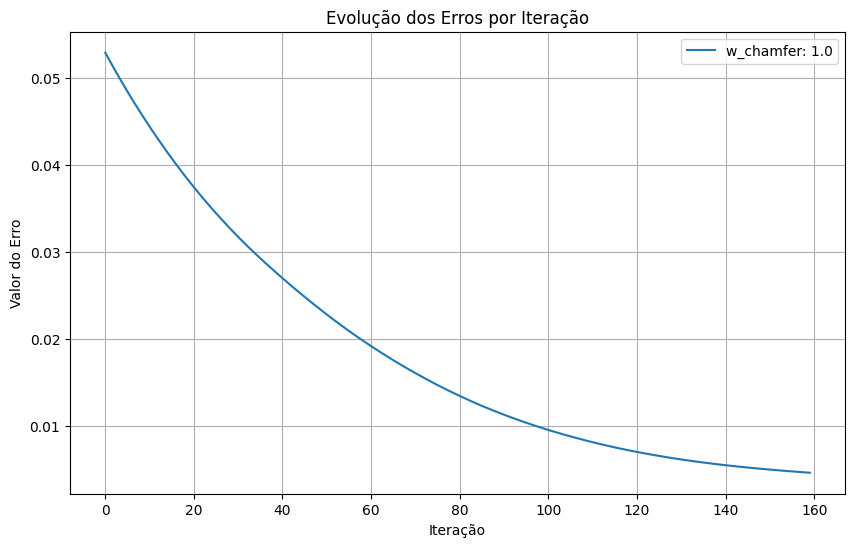

{'num_layers': 1, 'dimension': (3, 3, 3), 'learning_rate': 0.5, 'w_chamfer': 1.0, 'print_interval': 20, 'num_iterations': 160}


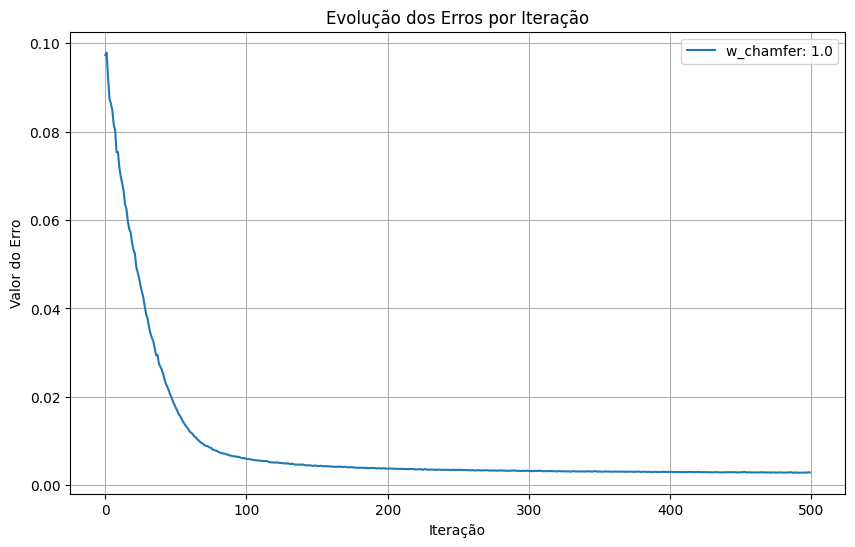

{'num_layers': 3, 'dimension': (3, 3, 3), 'learning_rate': 0.5, 'w_chamfer': 1.0, 'w_edge': 1.0, 'w_normal': 0.01, 'w_laplacian': 0.1, 'print_interval': 100, 'num_iterations': 500}


In [224]:
load8 = load_training_data("./treino_08.pkl")

for load in [load8,load3]:
    err_list = load['err_list']
    y = lambda x: x.detach().numpy() 
    
    if isinstance(err_list[0], torch.Tensor):
        erros_tratados = np.array([[float(xx)] for xx in err_list])
    else:    
        erros_tratados = np.array([[float(y(x)) for x in xx] for xx in err_list])

    iteracoes = np.arange(len(erros_tratados))  # [0, 1, 2, ..., 99]
    # Configurar o gráfico
    plt.figure(figsize=(10, 6))
    plt.title("Evolução dos Erros por Iteração")
    plt.xlabel("Iteração")
    plt.ylabel("Valor do Erro")

    legenda_erros = ['w_chamfer']
    # Plotar cada erro (4 no total)
    # for i in range(erros_tratados.shape[1]):  # Itera sobre as 4 colunas
    plt.plot(iteracoes, erros_tratados[:, 0], label=f"{legenda_erros[0]}: {load.get('params').get(legenda_erros[0])}")
        
    
    # Adicionar legendas e exibir o gráfico
    plt.legend()
    plt.grid(True)
    plt.show()
    print(load.get('params'))

## Versão com Multiplas camadas nn_sequential

In [9]:
from pytorch3d.ops import sample_farthest_points
from torchviz import make_dot

class FFDLayerSeq(nn.Module):
    def __init__(self, l, m, n, control_points=None, normalizer=None):
        """
        FFD Layer that applies deformation using Free Form Deformation (FFD).
        """
        super(FFDLayerSeq, self).__init__()
        self.dimension = (l, m, n)
        self.l, self.m, self.n = l, m, n

        # Normalizer function
        self.normalizer = normalizer

        # Control points grid
        if control_points is not None:
            self.control_points = control_points
        else:
            self.control_points = torch.tensor(
                np.array([[[[i / (l - 1), j / (m - 1), k / (n - 1)] 
                            for k in range(n)] 
                            for j in range(m)] 
                            for i in range(l)]).reshape(l * m * n, 3),
                requires_grad=False
            )
        
        # Control points delta (trainable parameter)
        self.control_points_delta = nn.Parameter(
            torch.zeros((l * m * n, 3), requires_grad=True)
        )

    def check_and_normalize(self, points):
        """
        Normalize points if necessary.
        """
        if not (torch.all(points >= 0) and torch.all(points <= 1)):
            if self.normalizer:
                points = self.normalizer(points)
            else:
                min_vals = points.min(dim=0, keepdim=True)[0]
                max_vals = points.max(dim=0, keepdim=True)[0]
                points = (points - min_vals) / (max_vals - min_vals)
        return points

    def forward(self, points):
        """
        Apply FFD deformation to points.
        """
        points = self.check_and_normalize(points)
        return FreeFormDeformation.apply(
            points, self.control_points, self.control_points_delta, self.l, self.m, self.n
        )


def train_from_points_seq(
    src_points, trg_verts,
    dimension=(3, 3, 3),
    learning_rate=0.5,
    num_layers=3,
    num_iterations=100,
    resolution=2000,
    w_chamfer=1.0,
    print_interval=10,
    **kwargs
):
    l, m, n = dimension
    error_hist = []

    # Control points grid
    control_points = torch.tensor(
        np.array([[[[i / (l - 1), j / (m - 1), k / (n - 1)] 
                    for k in range(n)] 
                    for j in range(m)] 
                    for i in range(l)]).reshape(l * m * n, 3),
        requires_grad=False,
        device=src_points.device
    )

    # Create FFD layers
    ffd_layers = [FFDLayerSeq(l=l, m=m, n=n, control_points=control_points) for _ in range(num_layers)]

    # Normalize source points
    src_points = ffd_layers[0].check_and_normalize(src_points[0])

    ffd_layers = nn.Sequential(
        *ffd_layers
    )
    
    # Configure optimizer
    optimizer = torch.optim.SGD(ffd_layers.parameters(), lr=learning_rate)

    # Sample target points
    sample_trg_verts, _ = sample_farthest_points(trg_verts, K=resolution)
    
    # Training loop
    for i in range(num_iterations):
        optimizer.zero_grad()

        # Apply FFD layers sequentially
        deformed_verts = ffd_layers(src_points)
        
        # Sample farthest points from deformed vertices
        sampled_points, _ = sample_farthest_points(deformed_verts.unsqueeze(0), K=resolution)
        
        # Compute Chamfer loss
        loss_chamfer_ffd, _ = chamfer_distance(sample_trg_verts, sampled_points)
        loss_ffd = loss_chamfer_ffd * w_chamfer

        error_hist.append(loss_chamfer_ffd.item())
        
        # Log loss
        print(f'Iteration {i + 1}/{num_iterations}, Loss: {loss_ffd.item():.6f}')
        if i % print_interval == 0:
            plot_pointcloud(deformed_verts)
        
        # Backpropagation
        make_dot(loss_ffd).render(f"ffd_graph_{i}", format="png")
        loss_ffd.backward()

        # Update control points deltas
        optimizer.step()

    # Return results
    return {
        'final_verts': deformed_verts,
        'delta_points': [layer.control_points_delta for layer in ffd_layers],
        'error_hist': error_hist
    }


Iteration 1/5, Loss: 0.051458


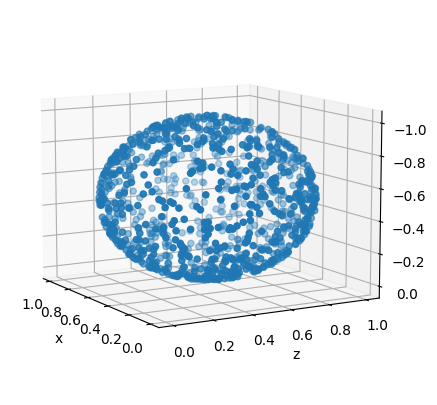

Iteration 2/5, Loss: 0.050550
Iteration 3/5, Loss: 0.049659


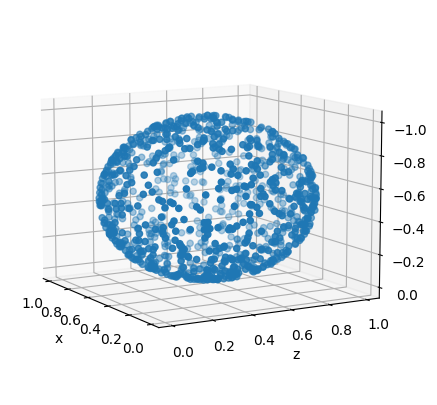

Iteration 4/5, Loss: 0.048782
Iteration 5/5, Loss: 0.047919


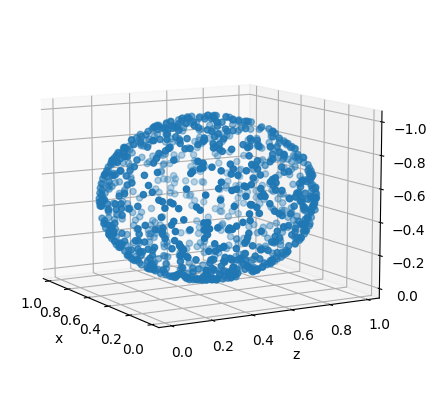

Dados salvos em ./treino_09.pkl


In [12]:

settings = {
    'num_layers' : 3,
    'dimension' : (3,3,3), 
    'learning_rate' : 0.5,
    # Loss weights
    'w_chamfer' : 1.0,
    'print_interval' : 2,
    'num_iterations' : 5
}

src_verts = sample_points_from_meshes( src_mesh, 1000) 
trg_verts = sample_points_from_meshes( trg_mesh, 1000) 

result = train_from_points_seq(src_verts, trg_verts, **settings)

final_verts = result["final_verts"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_verts, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_09.pkl' , data)

In [13]:
deltas

[Parameter containing:
 tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]], requires_grad=True),
 Parameter containing:
 tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0.